In [29]:
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate
#print('Using CAMB installed at '+ os.path.realpath(os.path.join(os.getcwd(),'..')))
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower
from scipy import integrate
from numpy import loadtxt

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams.update({'font.size': 11})

#### Load redshift bins and galaxy density n(z)

In [30]:
f=open('n_z.txt',"r")
lines=f.readlines()
z_bin=[];n_z=[]
for x in lines:
    z_bin.append(float(x.split(None)[0]))
    n_z.append(float(x.split(None)[1]))
f.close()

z_bin=np.array(z_bin)
n_z=np.array(n_z)

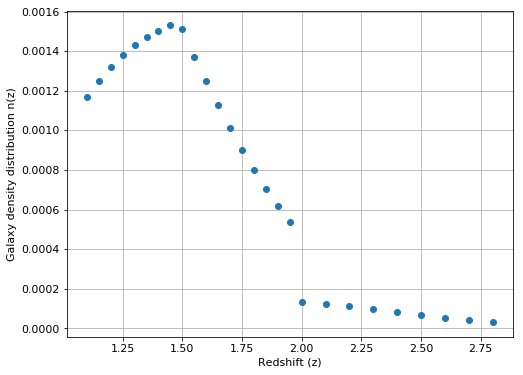

In [31]:
plt.plot(z_bin,n_z,'o')
plt.xlabel('Redshift (z)')
plt.ylabel('Galaxy density distribution n(z)')
plt.grid()

### Set fiducial cosmology

In [32]:
fid_params={'h':[0.675], 'Omb':[0.048], 'Omc':[0.268], 'ns':[0.965], 'As':[2e-09], 'w':[-1.0]}
print 'Fiducial Parameters:', fid_params

#List of fiducial parameters:
params_f=[p[0] for p in fid_params.itervalues()]

Fiducial Parameters: {'Omc': [0.268], 'Omb': [0.048], 'h': [0.675], 'As': [2e-09], 'w': [-1.0], 'ns': [0.965]}


In [33]:
n_pts=200
f_sky=0.08
n_spec=n_z/2.
n_phot=n_z/2.

theta=np.linspace(0,np.pi, 101)
mu=np.cos(theta)
sig_z=0.005

### Specify parameters to vary and step size

In [17]:
step_dict={'Omc':[0.005], 'ns':[0.01], 'w':[0.08]}
print 'Parameters to vary and step size:',step_dict

Parameters to vary and step size: {'Omc': [0.005], 'ns': [0.01], 'w': [0.08]}


In [28]:
def list_params(Step_dict, Fid_params):
    step_keys=[key for key in Step_dict.iterkeys()]
    keys=[p for p in Fid_params.iterkeys()]

    Params=dict(Fid_params)

    for i in keys:
        if i in step_keys:
            print i, Params[i], Fid_params[i][0]+Step_dict[i][0]
            Params[i].append(Fid_params[i][0]+Step_dict[i][0])
            Params[i].append(Fid_params[i][0]-Step_dict[i][0])
        Params[i].sort()
    return [Params[i] for i in keys], keys, step_keys

params_list, keys, step_keys=list_params(step_dict, fid_params)

Omc [0.263, 0.268, 0.273] 0.268
w [-1.08, -1.0, -0.92] -1.0
ns [0.955, 0.965, 0.975] 0.965


### Calculate matter power spectrum for various cosmologies

In [19]:
def Power_spectrum(param):
    Omc, Omb, h, A_s, w, n_s = param
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100.*h, ombh2=Omb*(h**2), omch2=Omc*(h**2.), omk=0)
    pars.set_dark_energy(w)
    pars.InitPower.set_params(As= A_s, ns=n_s)
    pars.set_matter_power(redshifts=z_bin, kmax=2.0)

    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = n_pts)
    
    if param==params_f:
        res_fid = camb.get_results(pars)
        return kh, pk, res_fid

    return kh, pk

def calculate_PS(Params_list, Params_f):
    PS=np.zeros((2*len(step_dict),len(z_bin), n_pts))
    l=0; keep=[]; vary=[];label=[]
    for i in range(len(Params_list)):
        for j in range(len(Params_list[i])):
            if len(Params_list[i])>1:
                par=list(Params_f)
                par[i]=Params_list[i][j]
                if par!=Params_f:
                    vary.append(Params_list[i][j])
                    print i, j, len(Params_list[i]), par
                    k, PS[l]=Power_spectrum(par)
                    l+=1
                    keep.append(i)
                    label.append(zip(keys, par))
    delete=[i for i in range(len(PS)) if i not in keep]
    label2= list(np.delete(np.array(label), delete,1))
    return k, PS, label2, vary
k, PS, label, vary=calculate_PS(params_list, params_f)

0 0 3 [0.263, 0.048, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)
0 2 3 [0.273, 0.048, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)


4 0 3 [0.268, 0.048, 0.675, 2e-09, -1.08, 0.965]
Note: redshifts have been re-sorted (earliest first)


4 2 3 [0.268, 0.048, 0.675, 2e-09, -0.92, 0.965]
Note: redshifts have been re-sorted (earliest first)
5 0 3 [0.268, 0.048, 0.675, 2e-09, -1.0, 0.955]
Note: redshifts have been re-sorted (earliest first)
5 2 3 [0.268, 0.048, 0.675, 2e-09, -1.0, 0.975]
Note: redshifts have been re-sorted (earliest first)


#### Fiducial Case

In [21]:
k, PS_fid, res_fid=Power_spectrum(params_f)
H_bar = np.array([res_fid.h_of_z(i) for i in z_bin])
r_z=np.array([res_fid.comoving_radial_distance(i) for i in z_bin])
c=299792.
print 'H(z)=', H_bar*c
PS_fid=PS_fid.reshape((1,len(z_bin),n_pts))
print PS_fid.shape

Note: redshifts have been re-sorted (earliest first)
H(z)= [ 128.49325278  132.25296141  136.08036789  139.9738019   143.9316816
  147.952509    152.03486533  156.17740646  160.37885855  164.63801379
  168.95372635  173.32490859  177.75052737  182.22960066  186.76119435
  191.34441915  195.97842785  200.66241263  205.39560265  215.00668597
  224.80616634  234.78899179  244.95051634  255.28645361  265.79283658
  276.46598263  287.30246323]
(1, 27, 200)


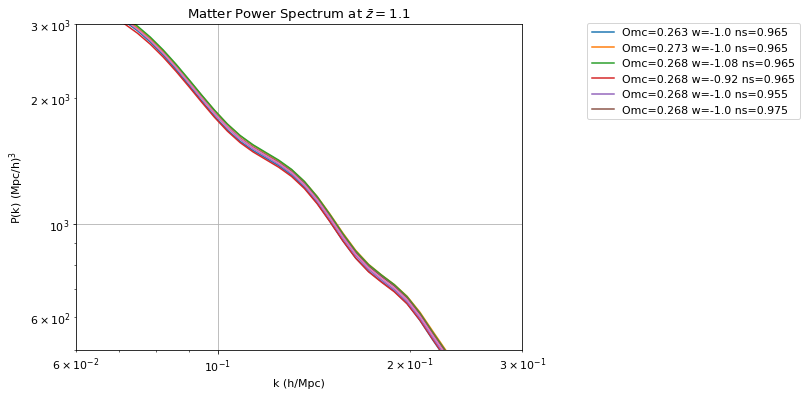

In [23]:
legend=[]
for i in range(len(label)):
    legend.append(' '.join([label[i][j][0]+'='+label[i][j][1] for j in range(len(label[i]))]))
ps=plt.loglog(k, PS[:,0,:].T)
ps_fid=plt.loglog(k, PS_fid[0][0])
plt.legend(ps, legend, bbox_to_anchor=(1.634, 1.02))
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'P(k) (Mpc/h)$^3$')
plt.title(r'Matter Power Spectrum at $\bar{z} = %s$'%(z_bin[0]))
plt.ylim(5*10**2, 3.*10**3)
plt.xlim(6*10**(-2), 0.3)
plt.grid()

### Calculating $P_{pp}$, $P_{sp}$ and $P_{ss}$

\begin{align}
P_{pp}(k, \mu, z) &= b^2_p |e^{-\frac{1}{2} k^2 \mu^2 \sigma^2_z/ H^2(z)}|^2 P(k, z) \\
P_{sp}(k,\mu, z) &= b_s b_p e^{-\frac{1}{2} k^2 \mu^2 \sigma^2_z/ H^2(z)} P(k, z) \\
P_{ss}(k, z) &= b^2_s P(k, z)
\end{align}

For the moment the biases $b_s$ and $b_p$ are set equal to 1.

In [24]:
def PS_pps(K, Mu, Sigma_z, H_bar, Power_Spectrum, Z_bin, n_PS):
    PS_pp, PS_sp, PS_ss = np.zeros((3, n_PS, len(z_bin), len(mu), n_pts))

    for i in range(n_PS):
        for j in range(len(Z_bin)):
            for l in range(len(Mu)):
                for m in range(len(K)):
                    PS_pp[i][j][l][m]=(abs(np.exp(-(((K[m])**2.)*((Mu[l])**2.)*((Sigma_z)**2.))/(2.*((H_bar[j])**2.))))**2.)*Power_Spectrum[i][j][m]
                    PS_sp[i][j][l][m]=(np.exp(-(((K[m])**2.)*((Mu[l])**2.)*((Sigma_z)**2.))/(2.*((H_bar[j])**2.))))*Power_Spectrum[i][j][m]
                    PS_ss[i][j][l][m]=Power_Spectrum[i][j][m]
            
    return PS_pp, PS_sp, PS_ss

P_pp, P_sp, P_ss = PS_pps(k, mu, sig_z, H_bar, PS, z_bin, len(PS))
Ppp_fid, Psp_fid, Pss_fid=PS_pps(k, mu, sig_z, H_bar, PS_fid, z_bin, 1)

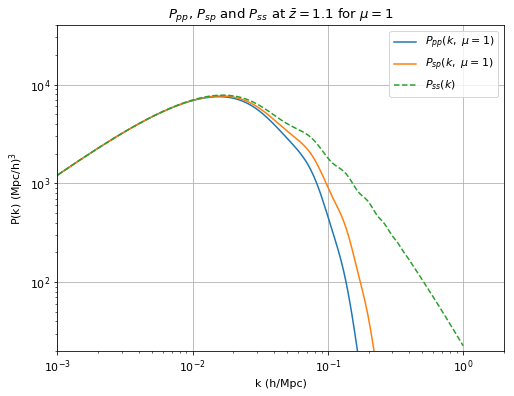

In [25]:
plt.loglog(k, Ppp_fid[0][0][0][:], label=r'$P_{pp}(k,\ \mu = 1)$')
plt.loglog(k, Psp_fid[0][0][0][:], label=r'$P_{sp}(k,\ \mu = 1)$')
plt.loglog(k, Pss_fid[0][0][0][:],'--', label=r'$P_{ss}(k)$')
plt.xlim(0.001, 2)
plt.ylim(2*10, 4*10**4)
plt.legend(loc='best')
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'P(k) (Mpc/h)$^3$')
plt.title(r'$P_{pp}$, $P_{sp}$ and $P_{ss}$ at $\bar{z} = %s$ for $\mu = 1$'%(z_bin[0]))
plt.grid()

### Derivatives

We will now take the derivative of the power spectra with respect to de parameters using central finite differences, i.e.

\begin{equation}
\frac{\partial P_{xy}}{\partial p} = \frac{P_{xy} (p=p_{fid}+\Delta p) - P_{xy} (p=p_{fid}-\Delta p)}{2\Delta p}
\end{equation}

In [26]:
def Derivative(Vary, PS_pp, PS_sp, PS_ss):
    dPS_pp, dPS_sp, dPS_ss = np.zeros((3, len(step_dict),len(z_bin), len(mu), n_pts))

    for i in range(len(Vary)/2):
        for j in range(len(z_bin)):
            dPS_pp[i][j]=(PS_pp[2*i+1][j]-PS_pp[2*i][j])/(Vary[2*i+1]-Vary[2*i])
            dPS_sp[i][j]=(PS_sp[2*i+1][j]-PS_sp[2*i][j])/(Vary[2*i+1]-Vary[2*i])
            dPS_ss[i][j]=(PS_ss[2*i+1][j]-PS_ss[2*i][j])/(Vary[2*i+1]-Vary[2*i])
    return dPS_pp, dPS_sp, dPS_ss
dP_pp, dP_sp, dP_ss = Derivative(vary, P_pp, P_sp, P_ss)

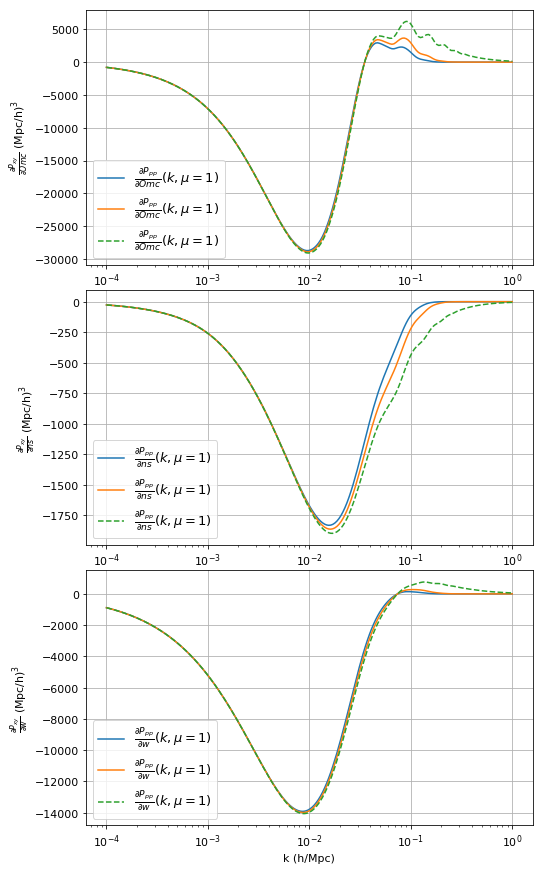

In [34]:
fig, axs = plt.subplots(len(PS)/2,1, figsize=(8, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1)

axs = axs.ravel()

for i in range(len(PS)/2):
    axs[i].plot(k, dP_pp[i,0,0,:], label=r'$\frac{\partial P_{pp}}{\partial %s} (k, \mu=1)$'%(step_keys[i]))
    axs[i].plot(k, dP_sp[i,0,0,:], label=r'$\frac{\partial P_{pp}}{\partial %s} (k, \mu=1)$'%(step_keys[i]))
    axs[i].plot(k, dP_ss[i,0,0,:],'--', label=r'$\frac{\partial P_{pp}}{\partial %s} (k, \mu=1)$'%(step_keys[i]))
    axs[i].legend(loc='best', prop={'size':13})
    axs[i].set_xscale('log')
    axs[i].set_xlabel('k (h/Mpc)')
    axs[i].set_ylabel(r'$\frac{\partial P_{xy}}{\partial %s}$ (Mpc/h)$^3$'%(step_keys[i]))
    axs[i].grid()

# Spectroscopic Fisher Matrix

\begin{align}
F_{lm} &= \int \frac{d^3 k\ d^3 x}{2(2\pi)^3} \frac{\partial P(k, z)}{\partial p_l} \frac{\partial P(k, z)}{\partial p_m} \left( \frac{1}{P(k, z) + \frac{1}{n(z)}} \right)^2 \\
&= \frac{f_{sky}}{\pi} \int k^2 dk \int^{z_{max}}_{z_{min}} \frac{r^2(z)}{H(z)} \frac{\partial P(k,z)}{\partial p_l}\frac{\partial P(k,z)}{\partial p_m} \left( \frac{1}{P(k,z) +\frac{1}{n(z)}} \right)^2
\end{align}

In [35]:
def Spec_FM(K, dP, P_fid, F_sky, H_bar, R_z, N_params, N_z, Z_bin):
    F_spec=np.zeros((N_params, N_params))
    integrand_z=np.zeros((len(Z_bin)))

    for i in range(N_params):
        for j in range(N_params):
            for l in range(len(Z_bin)):
                integrand_k=F_sky*(K**2.)*dP[i,l,0,:]*dP[j,l,0,:]*(1./((P_fid[l,0,:]+(1./N_z[l]))**2.))*(1./np.pi)*(((R_z[l])**2.)/(H_bar[l]))
                integrand_z[l] = integrate.simps(integrand_k, K)
            F_spec[i][j]=integrate.simps(integrand_z, z_bin)
    return F_spec

f_spec=Spec_FM(k, dP_ss, Pss_fid[0], f_sky, H_bar, r_z, len(step_dict), n_z, z_bin)

In [37]:
print 'Spectroscopic Fisher Matrix:'
print f_spec

Spectroscopic Fisher Matrix:
[[ 37589494.85688765  -1473306.33442638  11774584.85052837]
 [ -1473306.33442638     63001.67758581   -437944.06929915]
 [ 11774584.85052837   -437944.06929915   3887652.81073044]]


In [40]:
#inverse
print np.linalg.inv(f_spec)

[[  2.86743591e-06   3.08199315e-05  -5.21277547e-06]
 [  3.08199315e-05   4.04427920e-04  -4.77859261e-05]
 [ -5.21277547e-06  -4.77859261e-05   1.06621414e-05]]


# Spectroscopic and Photometric Fisher Matrix

\begin{align}
F_{lm} &= \int \frac{d^3 k\ d^3 x}{2(2\pi)^3} Tr\left[ \frac{\partial C}{\partial p_l} C^{-1} \frac{\partial C}{\partial p_m} C^{-1} \right] \\
&= \frac{f_{sky}}{2\pi} \int k^2 dk \int ^{1}_{-1} d \mu \int ^{z_{max}}_{z_{min}} \frac{r^2(z)}{H(z)} Tr\left[ \frac{\partial C}{\partial p_l} C^{-1} \frac{\partial C}{\partial p_m} C^{-1} \right],
\end{align}

\begin{equation}
C=
\left( \begin{array}{cccc}
P_{pp}(k,\mu, z)+\frac{1}{n_p(z)} & P_{sp}(k, \mu, z) \\
P_{sp}(k, \mu, z) & P_{ss}(k,z)+\frac{1}{n_s(z)} \\ \end{array} \right)
\end{equation}

#### Calculating the covariance matrix and trace

In [42]:
trace_M=np.zeros((len(step_dict), len(step_dict),len(z_bin), len(mu), n_pts))

for n in range(len(z_bin)):
    for l in range(len(mu)):
        for m in range(len(k)):
            C=np.zeros((2,2))
            dC=np.zeros((len(step_dict),2,2))
            C_inv=np.zeros((2,2))

            C[0][0]=Ppp_fid[0][n][l][m]+(1./n_phot[n])
            C[0][1]=Psp_fid[0][n][l][m]
            C[1][0]=Psp_fid[0][n][l][m]
            C[1][1]=Pss_fid[0][n][l][m]+(1./n_spec[n])

            dC[:,0,0]=dP_pp[:,n,l,m]
            dC[:,0,1]=dP_sp[:,n,l,m]
            dC[:,1,0]=dP_sp[:,n,l,m]
            dC[:,1,1]=dP_ss[:,n,l,m]

            C_inv=np.linalg.inv(C)

            for i in range(len(step_dict)):
                for j in range(len(step_dict)):
                    trace_M[i][j][n][l][m]=((k[m])**2.)*((r_z[n]**2.)/H_bar[n])*np.trace(np.dot(dC[i,:,:],np.dot(C_inv,np.dot(dC[j,:,:],C_inv))))

#### Integrating to get $F_{lm}$

In [43]:
integ_k=np.zeros((len(step_dict), len(step_dict), len(z_bin), len(mu)))
integ_mu=np.zeros((len(step_dict), len(step_dict), len(z_bin)))

for i in range(len(trace_M)):
    for j in range(len(trace_M)):
        for n in range(len(z_bin)):
            for l in range(len(mu)):
                integ_k[i][j][n][l]=integrate.simps(f_sky*trace_M[i][j][n][l]*(1./(2.*np.pi)), k)
            integ_mu[i][j][n]=integrate.simps(integ_k[i][j][n], mu)
    
F=np.zeros((len(step_dict), len(step_dict)))
F=integrate.simps(-integ_mu, z_bin)

In [45]:
print 'Photometric + Spectroscopic Fisher Matrix:'
print F

Photometric + Spectroscopic Fisher Matrix:
[[ 18417802.85560012   -760689.84817347   5395541.01504341]
 [  -760689.84817347     35360.65065051   -206303.46373614]
 [  5395541.01504341   -206303.46373614   1703748.64504233]]


In [46]:
#inverse
print np.linalg.inv(F)

[[  4.53472761e-06   4.69012223e-05  -8.68169388e-06]
 [  4.69012223e-05   5.81425313e-04  -7.81262030e-05]
 [ -8.68169388e-06  -7.81262030e-05   1.86205455e-05]]


### Consistency checks

In [47]:
sigma_w = loadtxt("sigma_w.txt", comments="#", delimiter=",", unpack=False)
sigma_cdm = loadtxt("sigma_cdm.txt", comments="#", delimiter=",", unpack=False)
sigma_ns = loadtxt("sigma_ns.txt", comments="#", delimiter=",", unpack=False)

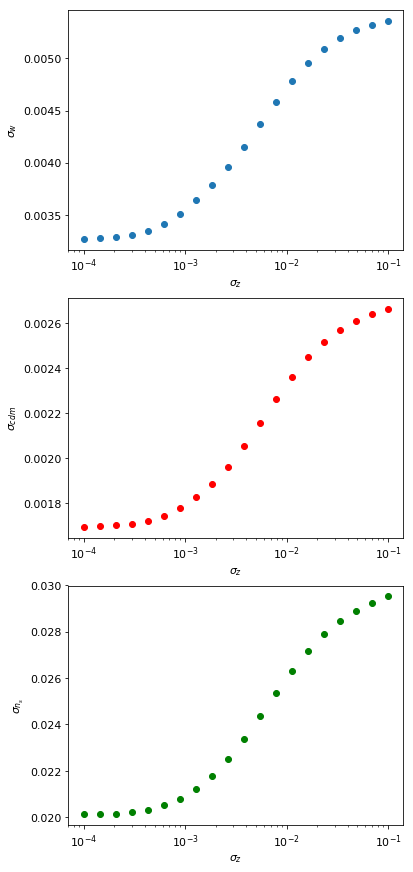

In [48]:
plt.rcParams['figure.figsize'] = (6, 15)

sigma_z=np.logspace(-4,-1,20)
plt.subplot(3,1,1)
plt.plot(sigma_z,sigma_w,'o')
plt.xlabel(r'$\sigma_z$')
plt.ylabel(r'$\sigma_w$')
plt.xscale('log')

plt.subplot(3,1,2)
plt.plot(sigma_z,sigma_cdm,'ro')
plt.xlabel(r'$\sigma_z$')
plt.ylabel(r'$\sigma_{cdm}$')
plt.xscale('log')

plt.subplot(3,1,3)
plt.plot(sigma_z,sigma_ns,'go')
plt.xlabel(r'$\sigma_z$')
plt.ylabel(r'$\sigma_{n_s}$')
plt.xscale('log')